In [33]:
import tqdm

import numpy as np
import pandas as pd
import seaborn as sns  
import matplotlib.pyplot as plt

from scipy.fft import fft
from scipy.stats import pearsonr, probplot
from scipy.optimize import minimize
from scipy.signal import find_peaks
from scipy.signal.windows import blackman, hamming

In [34]:
MODE_MODEL = "random-forest"
MODE_DEVICE = ""

## Data Loading

In [35]:
df = pd.read_csv("../data/ready-20241123.csv", sep=";", decimal=",", parse_dates=["Tanggal Mikrotest"], dayfirst=True)

# remove zeros
df = df[df["Hb Gold"] > 0]

# filter by device
if MODE_DEVICE != "":
    df = df[df["ID Alat"] == MODE_DEVICE]

df.head()

,No,Nama,Umur,ID Pasien di Alat,Tanggal Mikrotest,ID Alat,Hb Gold,Hb Silver,Hb Alat,D0001,...,D7991,D7992,D7993,D7994,D7995,D7996,D7997,D7998,D7999,D8000
0,1,Alya Ashanty Pandiangan,20,25,2024-11-09,HB-01,12.1,0.0,14.02935,487.0,...,58911.0,58913.0,58918.0,58910.0,58930.0,58938.0,58910.0,58928.0,58905.0,58920.0
1,1,Alya Ashanty Pandiangan,20,25,2024-11-09,HB-04,12.1,0.0,13.33600,521.0,...,59189.0,59190.0,59194.0,59202.0,59182.0,59206.0,59186.0,59206.0,59189.0,59186.0
2,1,Alya Ashanty Pandiangan,20,25,2024-11-09,HB-05,12.1,0.0,11.53419,573.0,...,59434.0,59419.0,59434.0,59426.0,59430.0,59442.0,59435.0,59441.0,59425.0,59430.0
3,1,Alya Ashanty Pandiangan,20,25,2024-11-09,HB-06,12.1,0.0,13.90464,563.0,...,58526.0,58550.0,58542.0,58533.0,58548.0,58536.0,58542.0,58553.0,58528.0,58544.0
4,1,Alya Ashanty Pandiangan,20,25,2024-11-09,HB-08,12.1,0.0,14.45103,573.0,...,58546.0,58532.0,58538.0,58530.0,58534.0,58540.0,58516.0,58549.0,58543.0,58540.0


In [36]:
df["ID Alat"].unique()

array(['HB-01', 'HB-04', 'HB-05', 'HB-06', 'HB-08', 'HB-14', 'HB-17'],
      dtype=object)

## EDA

In [37]:
# plt.figure(figsize=(20, 4))
# plt.plot(df.iloc[0, 9:].values)

In [38]:
# baseline = np.mean(df.iloc[0, 9:].values[:2000])
# segments = np.split(df.iloc[0, 9:].values[2000:], 30)
# baseline, len(segments), segments[0].shape

In [39]:
# corrected_segments = np.array([segment - baseline for segment in segments]).ravel()
# corrected_segments

In [40]:
# plt.figure(figsize=(20, 4))
# plt.plot(range(corrected_segments.shape[0]), corrected_segments)

In [41]:
# signal = df.iloc[0, 9:].values
# w = hamming(signal.shape[0])
# xw = np.abs(fft(signal * w))[1:signal.shape[0]//2]
# xx = np.abs(fft(signal))[1:signal.shape[0]//2]

# fig, ax = plt.subplot_mosaic("AA;BC", constrained_layout=True)
# ax["A"].plot(signal)
# ax["A"].set_title("Raw signal")
# ax["A"].set_xlabel("Time")
# ax["A"].set_ylabel("Sensor reading")

# ax["B"].semilogy(xx)
# ax["B"].set_title("FFT signal")
# ax["B"].set_xlabel("Frequency")
# ax["B"].set_ylabel("Amplitude")

# ax["C"].semilogy(xw)
# ax["C"].set_title("FFT signal with Hamming window")
# ax["C"].set_xlabel("Frequency")
# ax["C"].set_ylabel("Amplitude")

## Preprocessing

In [42]:
X = df.iloc[:, 9:].fillna(0).values
y = df.iloc[:, 6].values

X.shape, y.shape

((935, 8000), (935,))

In [43]:
# baseline correction
X_corrected = X[:, 2000:] - np.mean(X[:, :2000], axis=1).reshape(-1, 1)
# X_corrected = X

w = hamming(X_corrected.shape[1])
X_corrected = np.abs(fft(X_corrected * w))[:, :X_corrected.shape[1]//2]
# X_corrected = np.abs(fft(X_corrected))[:, :X_corrected.shape[1]//2]

X_corrected.shape

(935, 3000)

In [44]:
X_corr = []
for i in tqdm.trange(X_corrected.shape[1]):
    r, p = pearsonr(X_corrected[:, i], y)
    X_corr.append((i, r))

sr_corr = pd.Series([x[1] for x in X_corr], index=[x[0] for x in X_corr])
sr_corr.head()

100%|██████████| 3000/3000 [00:02<00:00, 1212.66it/s]


0    0.028550
1    0.054792
2    0.047204
3    0.027464
4    0.012013
dtype: float64

In [45]:
sr_corr.to_csv(f"{MODE_DEVICE}-corr.csv", index=False)

In [46]:
cols_corr = sr_corr.sort_values(ascending=False).index.tolist()
# cols = [*cols_corr[:3], *cols_corr[-3:]]
cols = cols_corr[:20]
cols

[2072,
 1892,
 2342,
 1265,
 2045,
 568,
 2492,
 440,
 2068,
 2942,
 2218,
 1505,
 65,
 545,
 2414,
 1325,
 2278,
 1903,
 287,
 485]

In [47]:
# get X, y
X_sel = X[:, cols]
X_sel.shape

(935, 20)

## Regressor

### Cross-Validation

In [48]:
from sklearn.ensemble import VotingRegressor
from sklearn.model_selection import cross_validate, cross_val_score, train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, root_mean_squared_error

from xgboost import XGBRegressor
from lightgbm.sklearn import LGBMRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

In [49]:
def create_model(xgb_weight=0.5):
    if MODE_MODEL == "decision-tree":
        return DecisionTreeRegressor()
    elif MODE_MODEL == "random-forest":
        return RandomForestRegressor(random_state=24, max_depth=8)
    elif MODE_MODEL == "xgboost":
        return XGBRegressor(random_state=42)
    elif MODE_MODEL == "lightgbm":
        return LGBMRegressor(random_state=42)
    elif MODE_MODEL == "voting":
        return VotingRegressor([("xgb", XGBRegressor(verbosity=0, random_state=42)), ("lgbm", LGBMRegressor(silent=True, verbose=-1, random_state=42))], weights=[xgb_weight, 1-xgb_weight])

In [50]:
scores = cross_validate(create_model(), X_sel, y, scoring=["r2", "neg_mean_absolute_error", "neg_mean_squared_error", "neg_root_mean_squared_error"])
scores_df = pd.DataFrame(scores)
scores_df

,fit_time,score_time,test_r2,test_neg_mean_absolute_error,test_neg_mean_squared_error,test_neg_root_mean_squared_error
0,0.487479,0.005798,-0.102763,-1.126265,-2.195339,-1.481668
1,0.471761,0.004761,-0.714217,-1.152254,-2.095175,-1.447472
2,0.474538,0.004926,-0.223422,-1.383931,-3.832065,-1.957566
3,0.488765,0.005363,-0.072890,-1.523352,-3.469575,-1.862680
4,0.478743,0.005267,-0.094032,-1.409182,-3.180059,-1.783272


In [51]:
scores_df.mean()

fit_time                            0.480257
score_time                          0.005223
test_r2                            -0.241465
test_neg_mean_absolute_error       -1.318997
test_neg_mean_squared_error        -2.954443
test_neg_root_mean_squared_error   -1.706531
dtype: float64

### Optimize Weight for Voting

In [52]:
# def optim_fun(x, xt, yt):
#     return np.abs(np.mean(cross_val_score(create_model(x[0]), xt, yt, scoring="neg_mean_squared_error", verbose=0)))

# res = minimize(optim_fun, x0=0.5, args=(X_sel, y), method="Nelder-Mead", tol=1e-4)
# res

### Hold-out

In [53]:
X_train, X_test, y_train, y_test = train_test_split(X_sel, y, test_size=0.3, random_state=24)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((654, 20), (281, 20), (654,), (281,))

In [54]:
# reg = create_model(res.x[0])
reg = create_model()
reg.fit(X_train, y_train)

RandomForestRegressor(max_depth=8, random_state=24)

In [55]:
reg.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': 8,
 'max_features': 1.0,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 24,
 'verbose': 0,
 'warm_start': False}

In [56]:
y_pred = reg.predict(X_test)
resid = y_test - y_pred

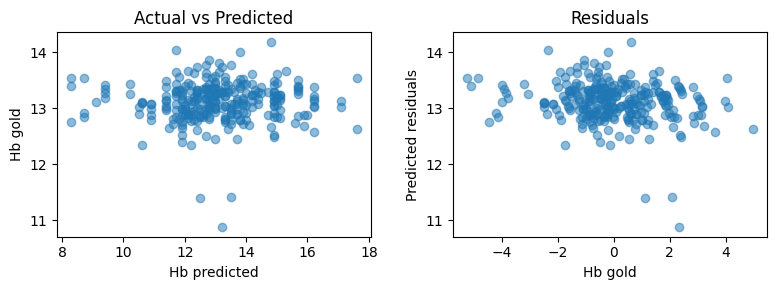

In [57]:
fig, ax = plt.subplots(1, 2, figsize=(8, 3))
ax[0].scatter(y_test, y_pred, alpha=0.5)
ax[0].set_title("Actual vs Predicted")
ax[0].set_xlabel("Hb predicted")
ax[0].set_ylabel("Hb gold")

ax[1].set_title("Residuals")
ax[1].scatter(resid, y_pred, alpha=0.5)
ax[1].set_xlabel("Hb gold")
ax[1].set_ylabel("Predicted residuals")

fig.tight_layout()
plt.show()

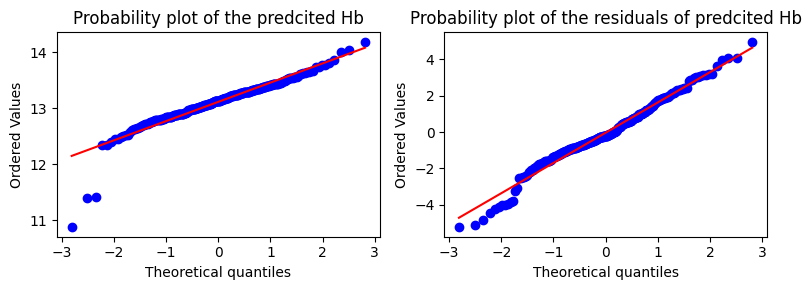

In [58]:
fig, ax = plt.subplots(1, 2, figsize=(8, 3))

probplot(y_pred, dist="norm", plot=ax[0])
ax[0].set_title("Probability plot of the predcited Hb")

probplot(resid, dist="norm", plot=ax[1])
ax[1].set_title("Probability plot of the residuals of predcited Hb")

fig.tight_layout()
plt.show()

### Evaluate Performance

In [65]:
# df_pred = pd.DataFrame({
#     "hb_gold": y_test,
#     "hb_pred" : reg.predict(X_test)
# }).sort_values("hb_gold")

df_pred = pd.DataFrame({
    "hb_gold": y,
    "hb_pred" : reg.predict(X[:, cols])
}).sort_values("hb_gold")

In [66]:
r, _ = pearsonr(df_pred["hb_gold"], df_pred["hb_pred"])

print(f"R = {r:.4f}")
print(f"R2 = {r2_score(df_pred['hb_gold'], df_pred['hb_pred']):.4f}")
print(f"MAE = {mean_absolute_error(df_pred['hb_gold'], df_pred['hb_pred']):.4f}")
print(f"MSE = {mean_squared_error(df_pred['hb_gold'], df_pred['hb_pred']):.4f}")
print(f"RMSE = {root_mean_squared_error(df_pred['hb_gold'], df_pred['hb_pred']):.4f}")

R = 0.6446
R2 = 0.2937
MAE = 1.0673
MSE = 1.9240
RMSE = 1.3871


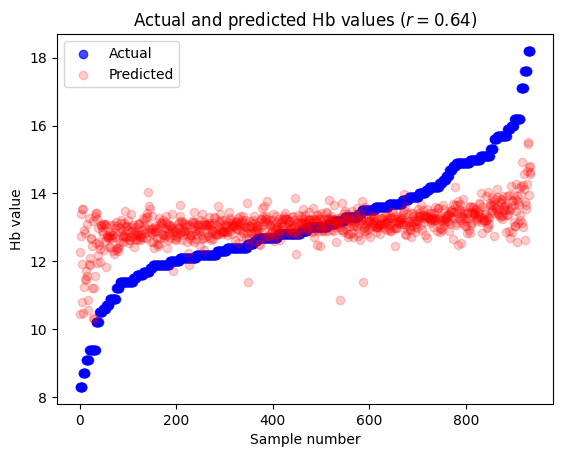

In [64]:
fig, ax = plt.subplots()  
ax.scatter(range(df_pred.shape[0]), df_pred["hb_gold"], c='b', alpha=0.7, label="Actual")
ax.scatter(range(df_pred.shape[0]), df_pred["hb_pred"], c='r', alpha=0.2, label="Predicted")
ax.legend()

ax.set_title(f"Actual and predicted Hb values ($r={r:.2f}$)")
ax.set_xlabel("Sample number")
ax.set_ylabel("Hb value")

plt.show()